In [1]:
import tables as t
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from tqdm import tqdm
import pandas as pd


In [2]:
data_dir = "/eos/user/f/fmirkovi/raw_data_analisys/data/"
save_dir = "/eos/user/f/fmirkovi/per_bin/"

file1 = "7921_channel_dict.json"
file2 = "vme_7921_channel_dict.json"

In [3]:
with open(data_dir + file1,'r') as f:
    ch_dict = json.load(f)
    
for k in ch_dict.keys():
    ch_dict[k] = np.array(ch_dict[k])
    

with open(data_dir + file2,'r') as f:
    vmech_dict = json.load(f)
    
for k in vmech_dict.keys():
    vmech_dict[k] = np.array(vmech_dict[k])

In [4]:

print(ch_dict.keys())
print(vmech_dict.keys())

dict_keys(['1', '45', '3', '37', '35', '39', '41', '7', '13', '15', '27', '17', '19', '22', '9', '25', '33', '47', '29', '5'])
dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48'])


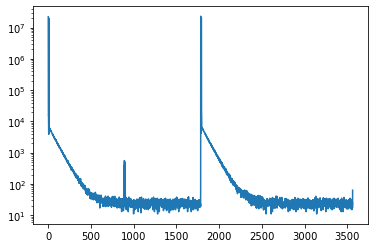

In [5]:
plt.plot(ch_dict["1"])
plt.yscale("log")

## Exponential fit and correction coeficients
In the cell bellow we define the simple exponential function to approximate the effect of the albedo. Also, we normalize the paramteres $a$ and $c$ with the rate of the colliding bunch to assure that correction factors are obtained. Lastly, the fit was performed on data that exluded first $start$ bunch crossings. The reason for this was twofold. First, if we begin the fith from bunch index 1 i.e. colliding bunches we get a false abledo model since rates caused by proton collisions are included in the data and we are looking soley for the albedo parameters. 
<br>
The second reason is numerical stability. We have found that excluding only a small number of bunch crossings after the colliding one still makes the algorithm unable to find the optimal parameters. This could be due to two types of albedo:<br>
Type 1: Shortly after collisions the material is still hot and produces a high amount of hits.
<br>
Type 2: Long expontential decay of irradiated material i.e. the one we are looking for.
<br>
This makes the $start$ variable a hyperparameter and the best results have been found for $start$ = 20 and the results do not vary greatly when 
<br>
$start$ $\in$$\langle$15,25$\rangle$

In [6]:
from scipy.optimize import curve_fit
def fit(x,a,lam,c):
    return a*np.exp(-lam*x) + c



def fit_albedo(ch_data,plot = True,start = 20,return_corrected = False):
    """
    Fits the albedo model.
    Paremeters a and c are normalized.
    Params:
    ch_data: numpy array contianing rates accross the LHC orbit
    plot: boolean that decides wether to plot results or not.
    start: bunch index where the fit should start from
    Returns: normalized fit parameters 
    """
    start = start
    x = np.linspace(start,1745,1745-start)*25e-9 #Time is expressed in seconds!!!
    al = ch_data#.reshape(-1,3564*4)
    al = (al[0:1745] + al[1785:3530])/2
    al[889:902] = [al[875:889].mean()]*13
    popt,cov = curve_fit(fit,x,al[start:])
    if plot:
        frame,fig = plt.subplots(figsize = (8,8))
        fig.plot(range(0,1745),al)
        fig.plot(range(start,1745),fit(x,popt[0],popt[1],popt[2]),color = "k",linestyle = "--")
        #fig.set_ylim(0,1000)
        fig.set_yscale("log")
    
    return popt[0]/al[0],popt[1],popt[2]/al[0]

Channel  1
Channel  2
Channel  3
Channel  4
Channel  5
Channel  6
Channel  7
Channel  8
Channel  9
Channel  10
Channel  11
Channel  12
Channel  13
Channel  14
Channel  15
Channel  16
Channel  17
Channel  18
Channel  19
Channel  20
Channel  21
Channel  22
Channel  23
Channel  24
Channel  25
Channel  26


/tmp/ipykernel_707/3558960752.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  frame,fig = plt.subplots(figsize = (8,8))


Channel  27
Channel  28
Channel  29
Channel  30
Channel  31
Channel  32
Channel  33
Channel  34
Channel  35
Channel  36
Channel  37
Channel  38
Channel  39
Channel  40
Channel  41
Channel  42
Channel  43
Channel  44
Channel  45
Channel  46
Channel  47
Channel  48


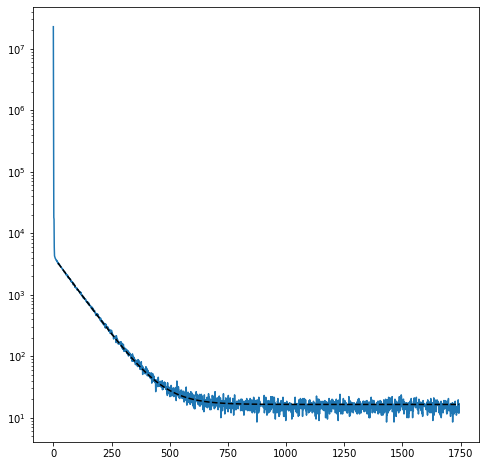

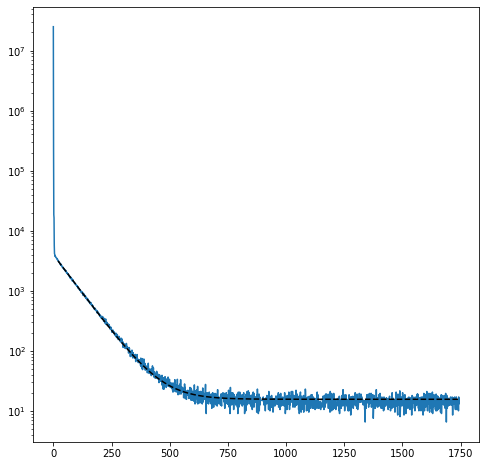

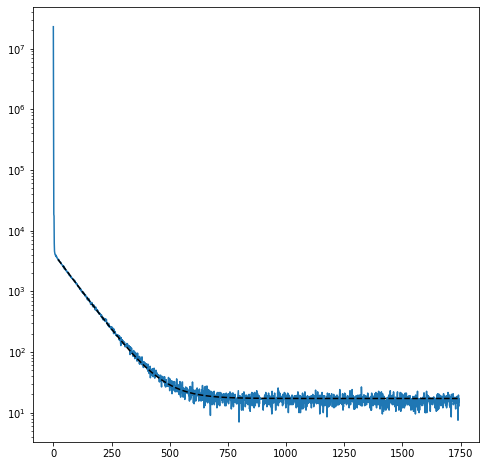

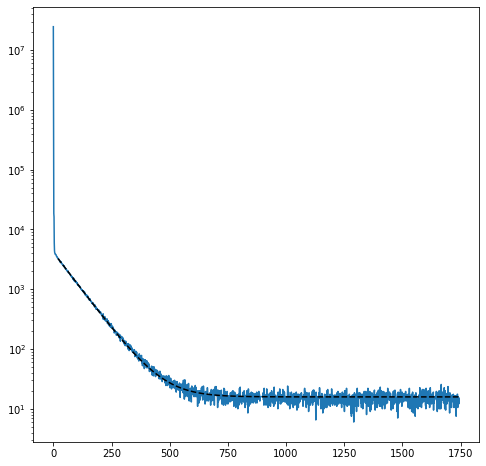

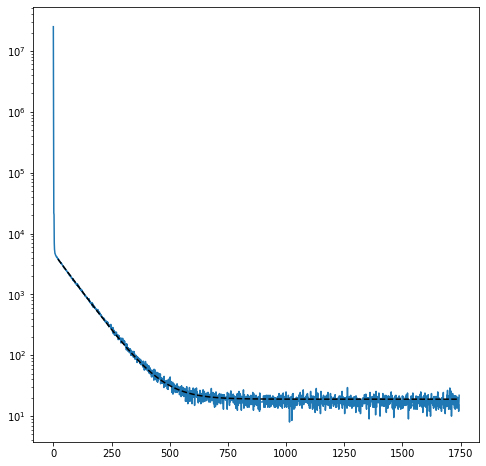

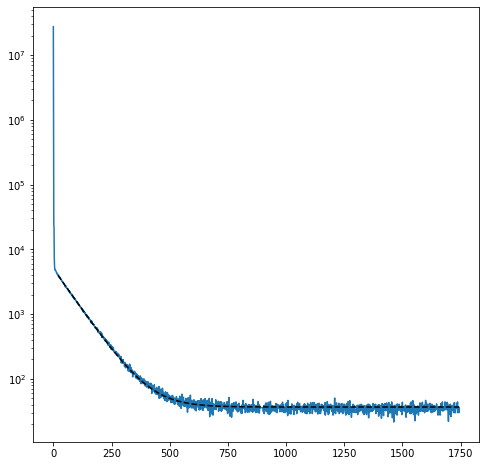

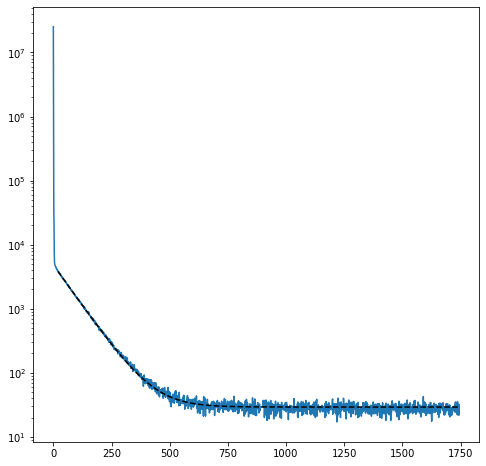

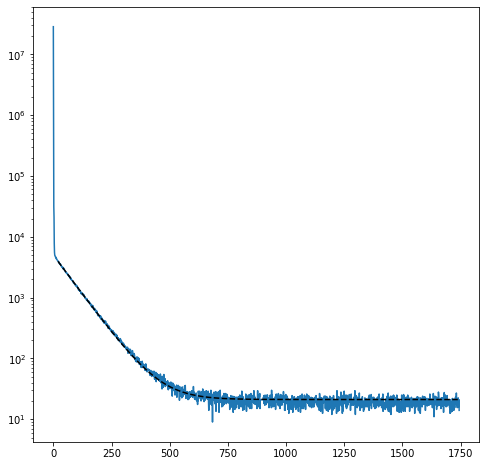

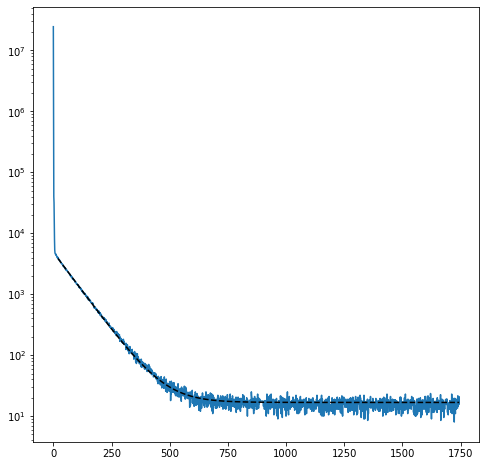

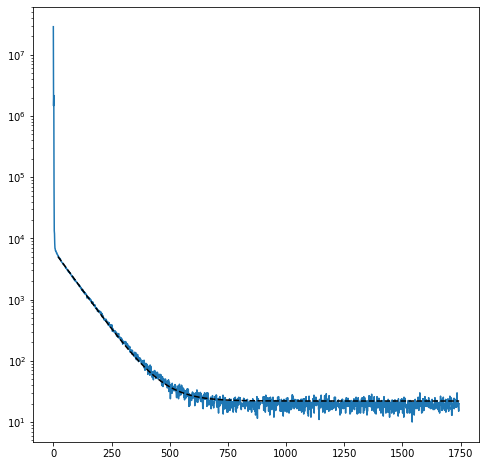

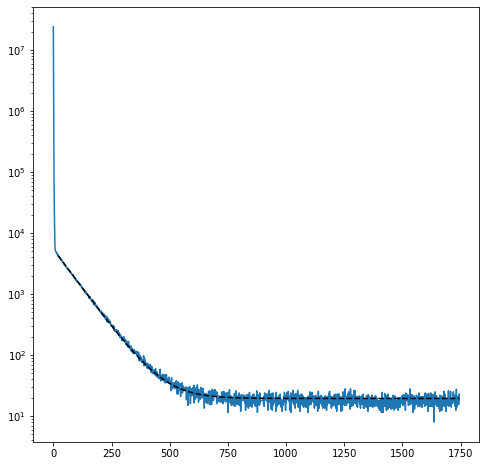

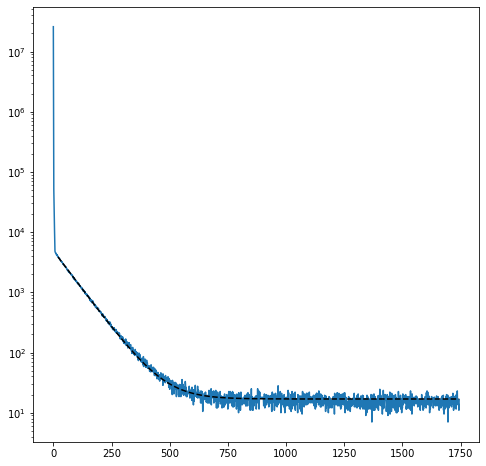

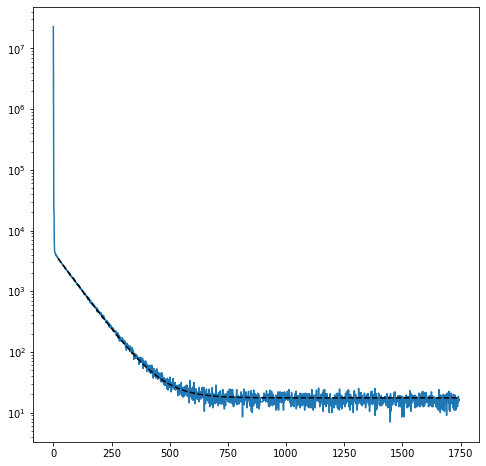

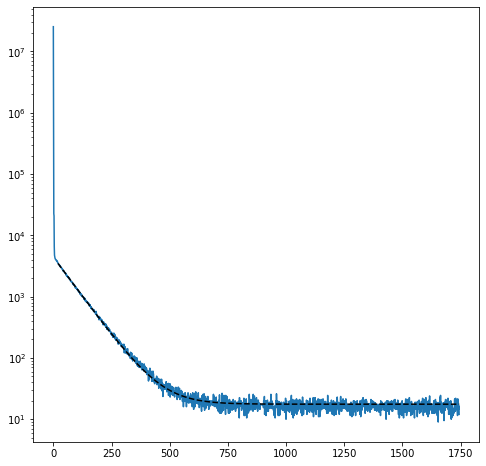

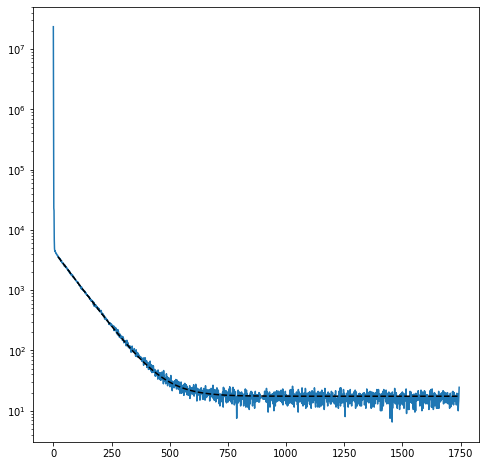

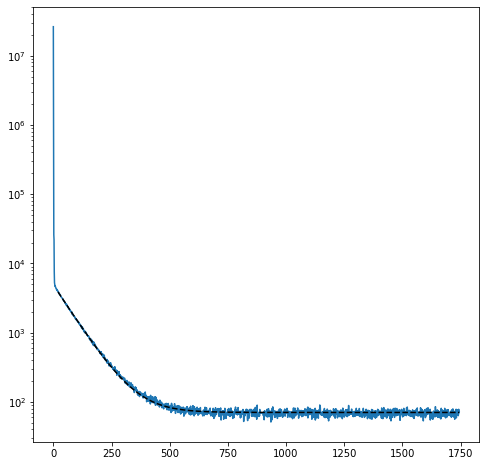

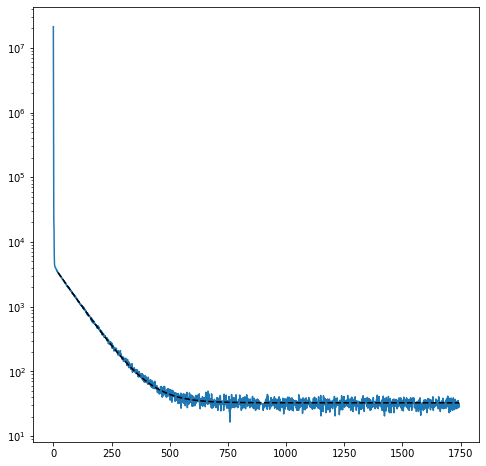

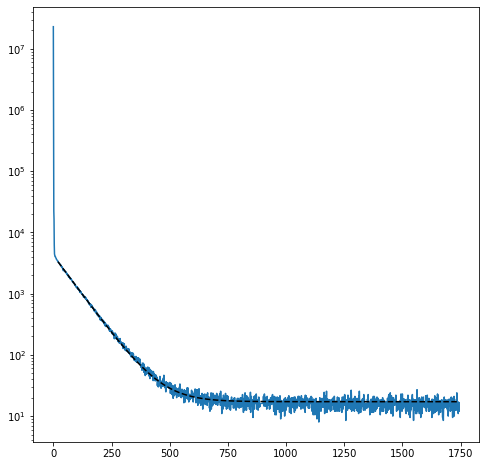

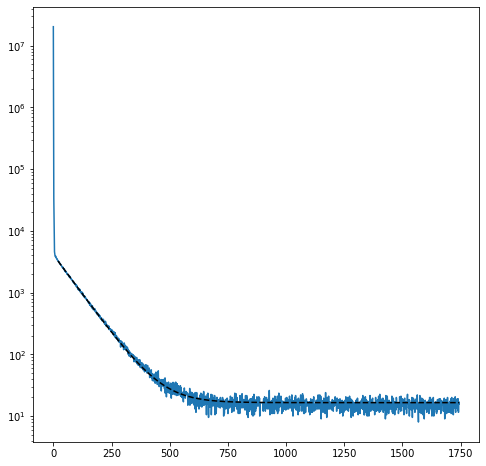

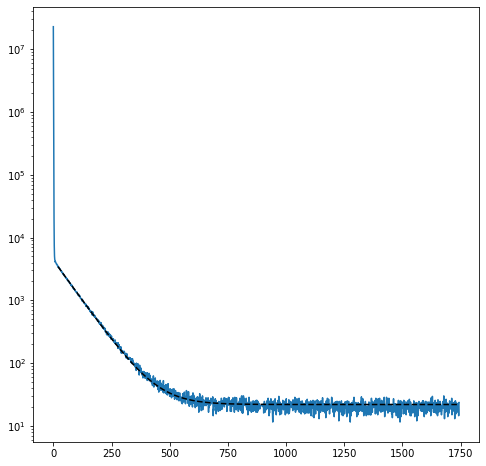

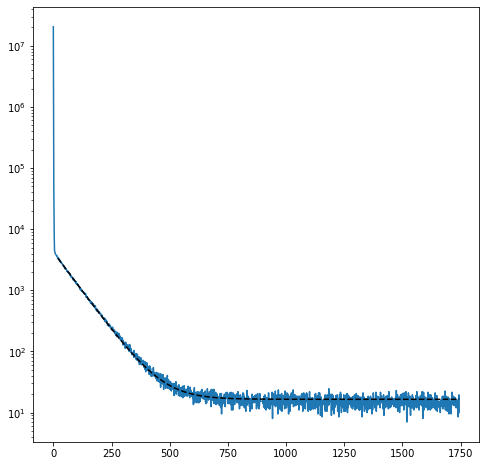

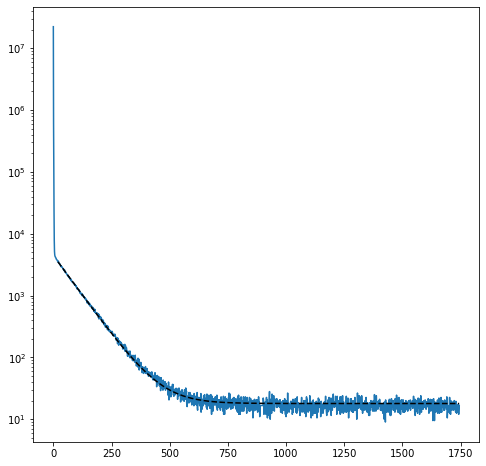

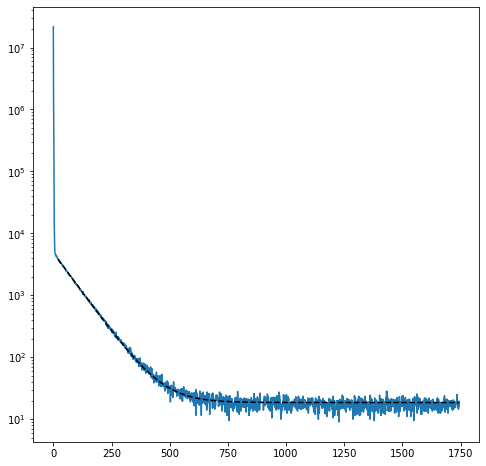

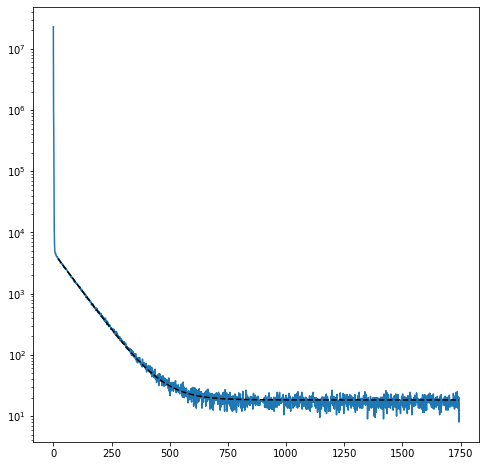

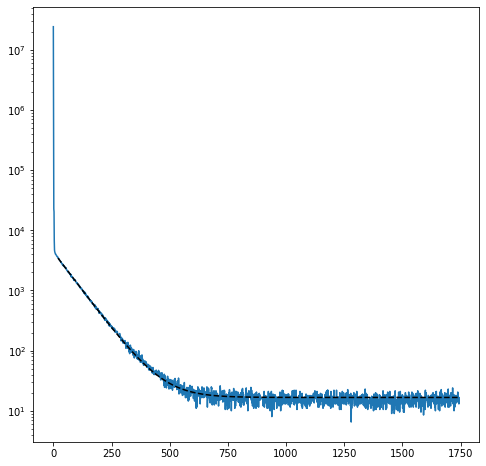

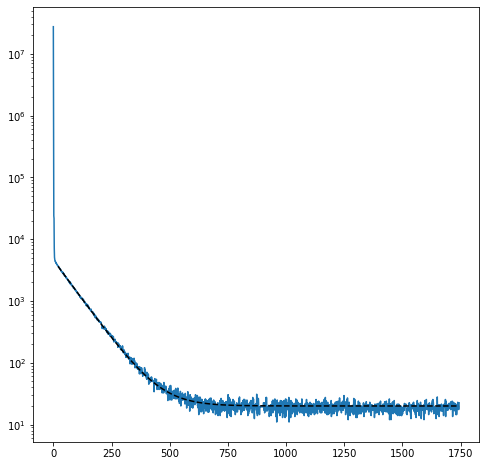

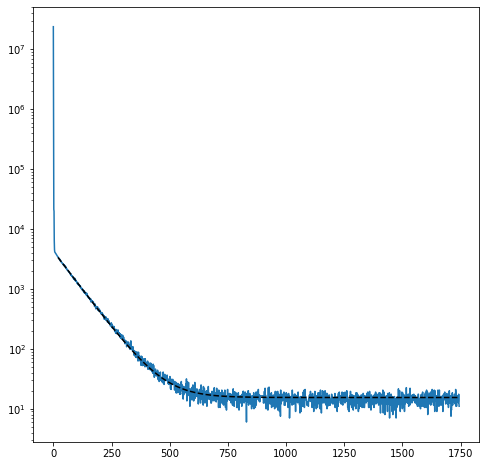

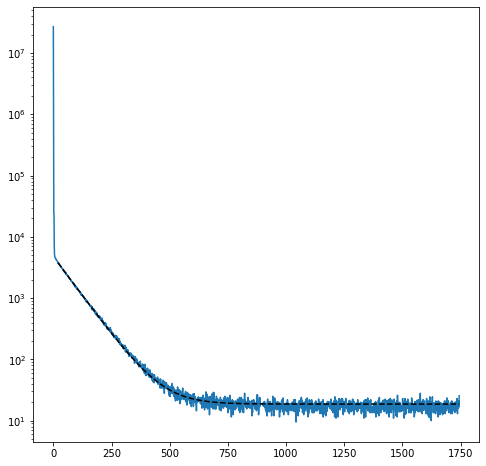

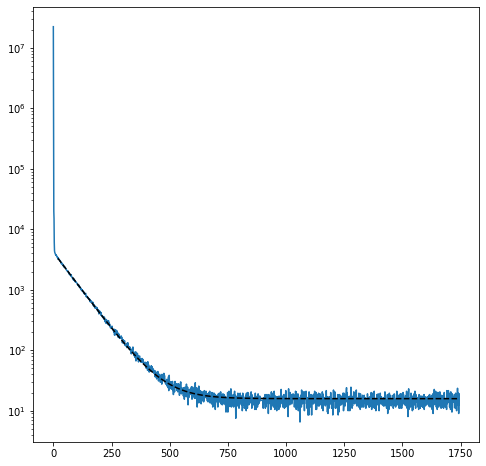

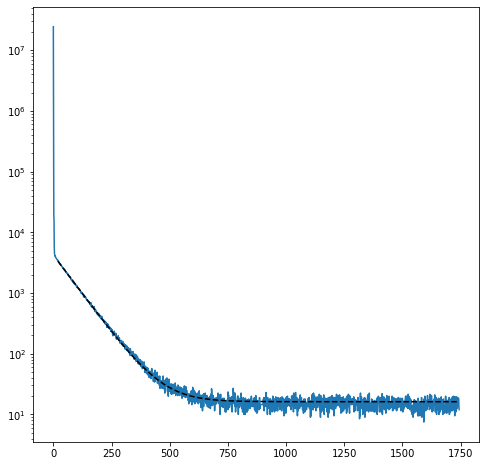

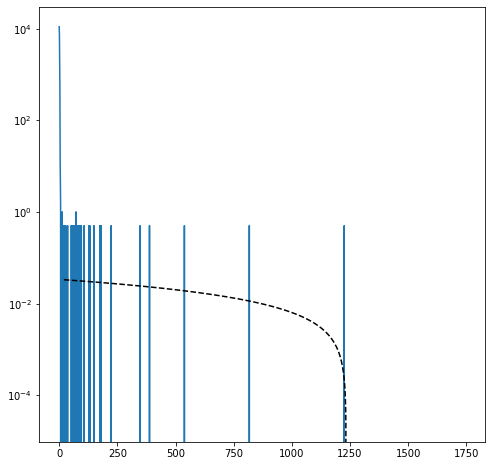

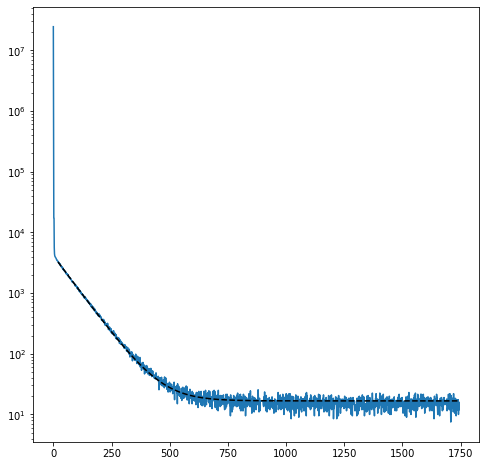

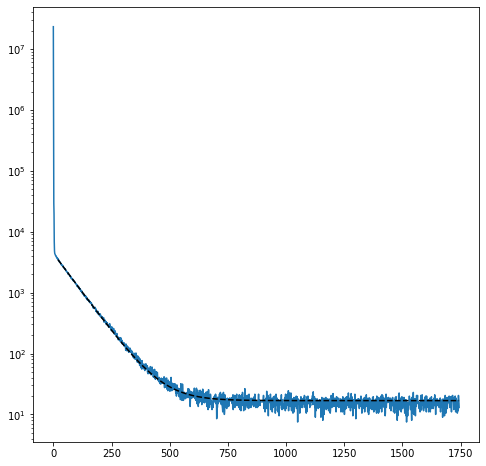

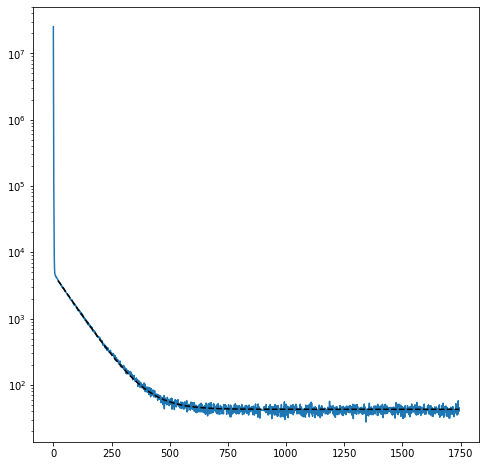

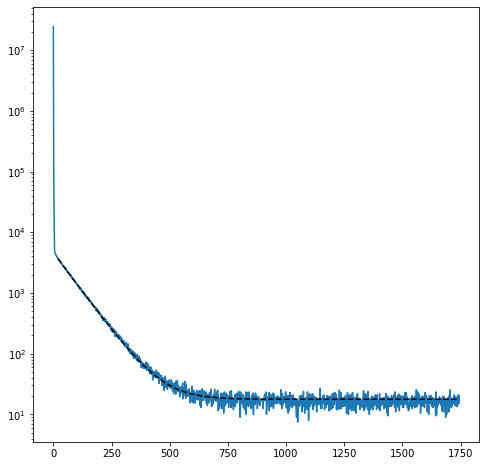

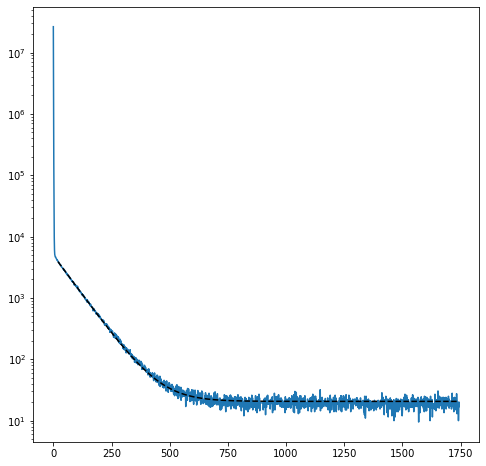

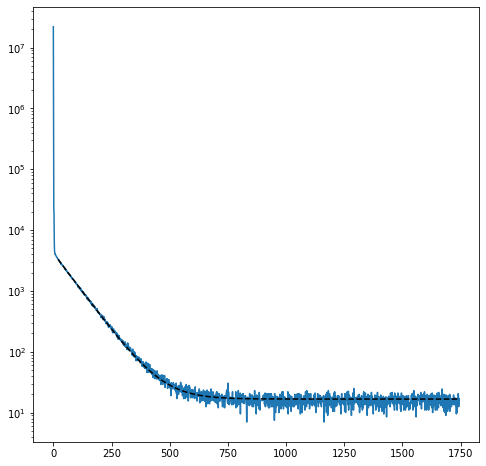

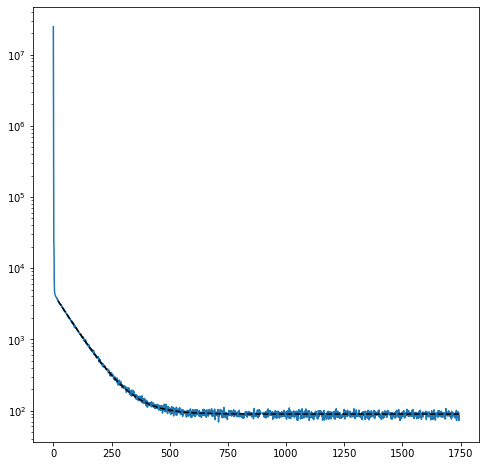

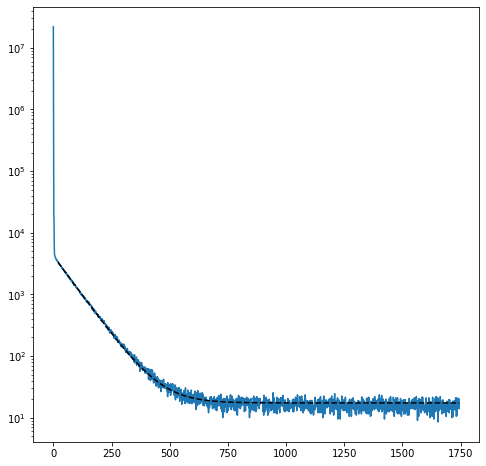

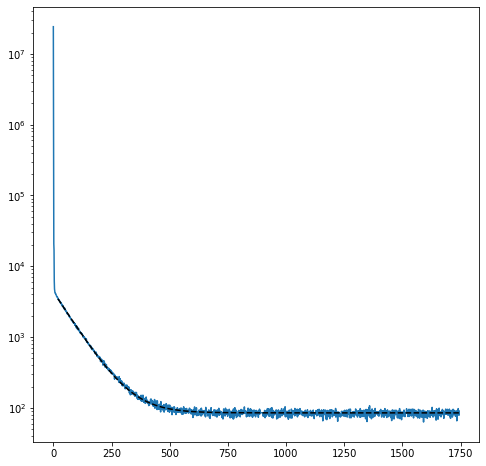

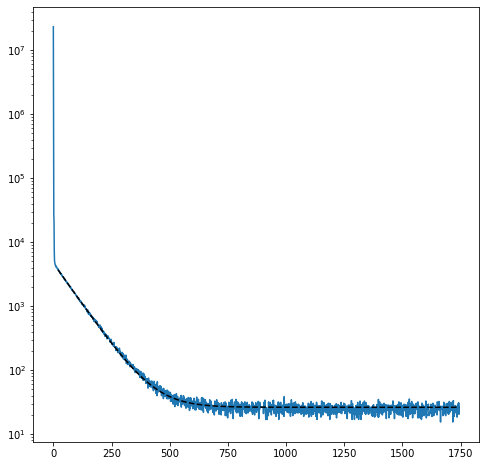

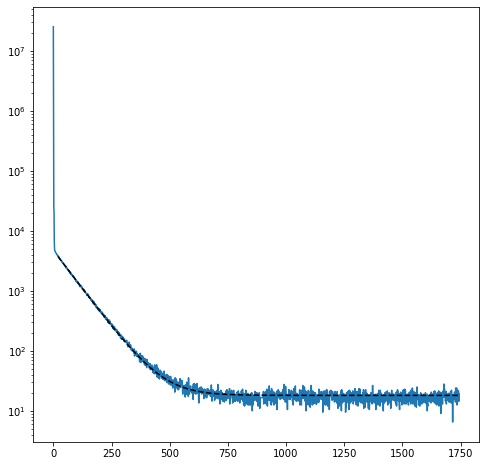

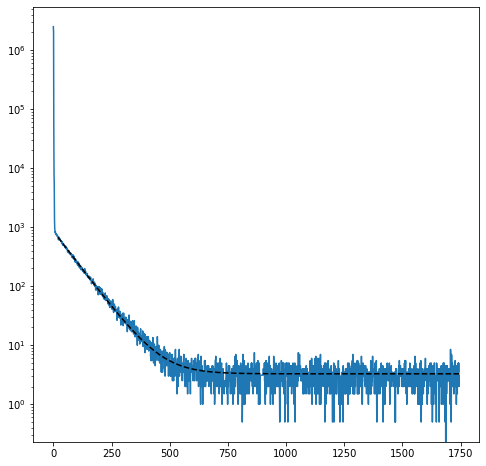

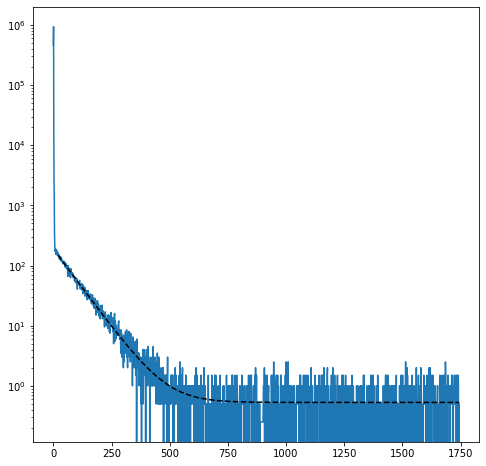

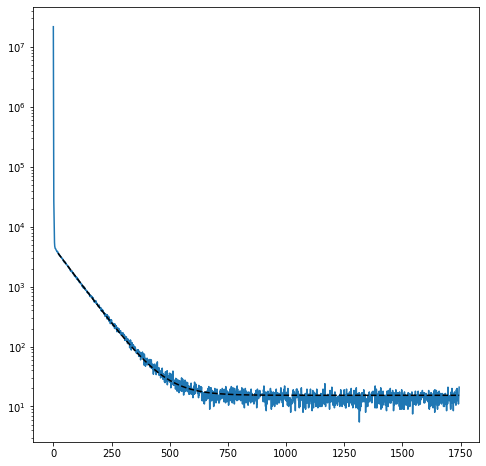

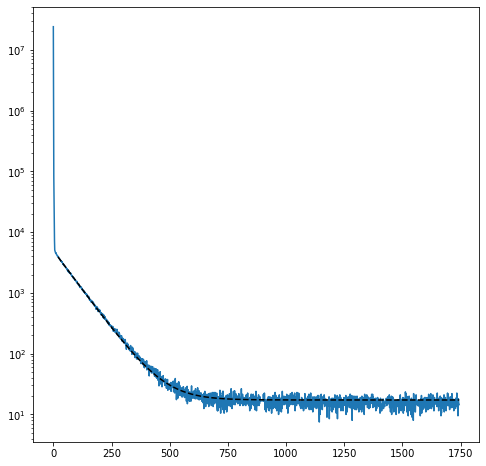

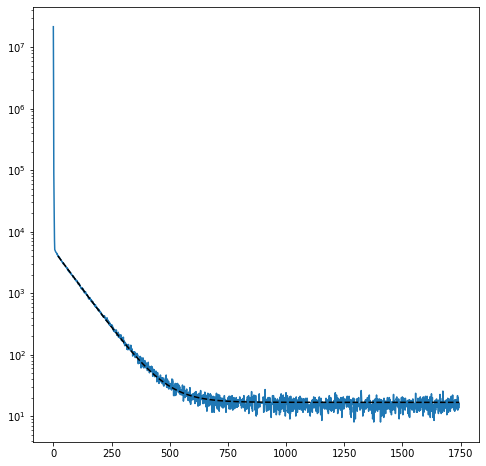

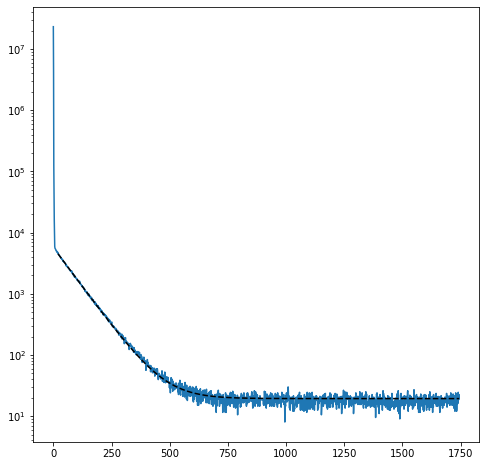

In [7]:
A = []
lams = []
C = []
chs = []
for ch in vmech_dict.keys():
    print(f"Channel  {ch}")
    try:
        a,lam,c = fit_albedo(vmech_dict[str(ch)],plot =True,start = 20)
        A.append(a)
        lams.append(lam)
        C.append(c)
        chs.append(ch)
    except:
        print("Problematic channel: " + ch)

### In the cells bellow we calculate the albedo exponential fit for uTCA and VME data
NOTE: The fit parameters are normalized with the colliding bunch rate, so they repersent correction factors.

In [8]:
A = []
lams = []
C = []
chs = []
for ch in ch_dict.keys():
    a,lam,c = fit_albedo(ch_dict[ch],plot =False,start = 5)
    A.append(a)
    lams.append(lam)
    C.append(c)
    chs.append(ch)
    
A = np.array(A)
lams = np.array(lams)
C = np.array(C)
chs = np.array(chs)
A = A[lams>0]
C = C[lams>0]
chs = chs[lams>0]
lams = lams[lams >0]*1e-6

fit_params = pd.DataFrame(data = {"channel":chs,"a":A,"lambda":lams,"c":C})

In [9]:
A = []
lams = []
C = []
chs = []
for ch in vmech_dict.keys():
    a,lam,c = fit_albedo(vmech_dict[ch],plot =False,start = 5)
    A.append(a)
    lams.append(lam)
    C.append(c)
    chs.append(ch)
    
A = np.array(A)
lams = np.array(lams)
C = np.array(C)
chs = np.array(chs)
A = A[lams>0]
C = C[lams>0]
chs = chs[lams>0]
lams = lams[lams >0]*1e-6

fit_params = pd.DataFrame(data = {"channel":chs,"a":A,"lambda":lams,"c":C})

/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [10]:
fit_params["tau"] = 1/fit_params["lambda"]

In [11]:
fit_params.mean()

channel    2.626740e+82
a          2.076543e-04
lambda     4.929331e-01
c          1.106203e-06
tau        2.030736e+00
dtype: float64

In [12]:
fit_params.std()

a         4.869715e-05
lambda    1.656482e-02
c         6.569764e-07
tau       6.277880e-02
dtype: float64

In [13]:
fit_params["tau"] = 1/fit_params["lambda"]

In [14]:
fit_params

,channel,a,lambda,c,tau
0,1,0.000185,0.482474,7.716338e-07,2.072652
1,2,0.000163,0.485950,6.740977e-07,2.057826
2,3,0.000189,0.482971,8.074978e-07,2.070518
3,4,0.000171,0.481119,6.908835e-07,2.078488
4,5,0.000197,0.488292,8.364514e-07,2.047956
5,6,0.000187,0.488755,1.403545e-06,2.046014
6,7,0.000196,0.486361,1.232525e-06,2.056088
7,8,0.000179,0.486269,8.006486e-07,2.056476
8,9,0.000211,0.502230,8.522827e-07,1.991120
9,10,0.000249,0.540163,1.110093e-06,1.851292


In [15]:
mean_params = fit_params.mean()
fit_params.mean()

channel    2.626740e+82
a          2.076543e-04
lambda     4.929331e-01
c          1.106203e-06
tau        2.030736e+00
dtype: float64

In [16]:
fit_params.std()

a         4.869715e-05
lambda    1.656482e-02
c         6.569764e-07
tau       6.277880e-02
dtype: float64

## Correction coefficients
The final correction parameters are found by taking their rispective means across all channels.

In [17]:
a = mean_params["a"]
lam = mean_params["lambda"]
c = mean_params["c"]

In [18]:
start = 0
x = np.linspace(start,1745,1745-start)*25e-9

In [19]:
correct = a*np.exp(-lam*x*1e6) + c
print(correct.shape)

(1745,)


## Corrected rates for channel 1

In [20]:
x1 = np.linspace(start,1785,1785-start)*25e-9
x2 = np.linspace(0,3564-1785,1779-start)*25e-9
corr1 = a*np.exp(-lam*x1*1e6) + c
corr2 = a*np.exp(-lam*x2*1e6) + c

y1 = vmech_dict["1"][start:1785] - vmech_dict["1"][0]*corr1
y2 = vmech_dict["1"][1785:] - vmech_dict["1"][1785]*corr2
y = np.concatenate([y1,y2])

### After the correction there seems to be a bump in the rates of order of magnitude $10^1$

Text(0.5, 1.0, 'Rates ber BXID after albedo correction')

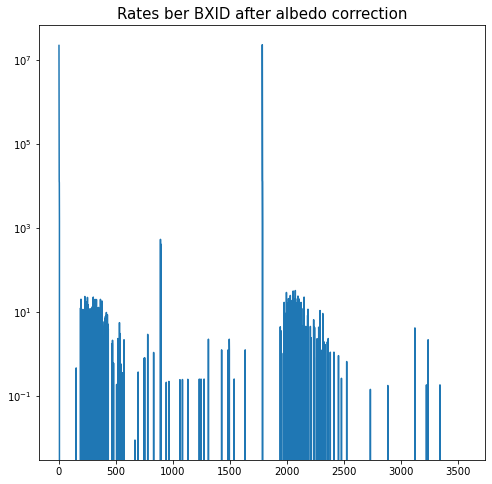

In [21]:
_,fig = plt.subplots(figsize = (8,8))
plt.plot(y)
plt.yscale("log")
plt.title("Rates ber BXID after albedo correction",fontsize = 15)


### However this can be attributed to the model overestimating te albedo near the colliding bunches

Text(0.5, 1.0, 'Zoom In')

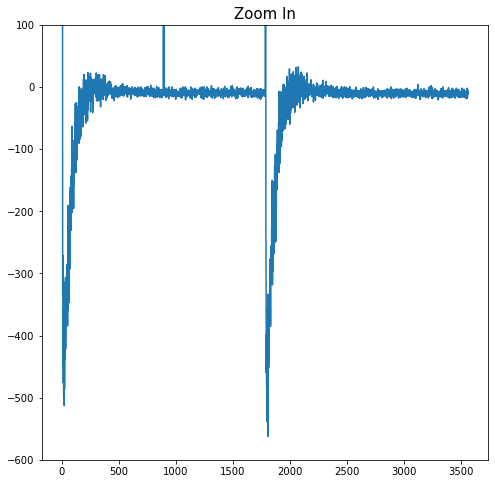

In [22]:
_,fig = plt.subplots(figsize = (8,8))
plt.plot(y)
plt.ylim(-600,100)
plt.title("Zoom In",fontsize = 15)

In [23]:
mean_params.to_json()

'{"channel":2.626740194e+82,"a":0.0002076543,"lambda":0.4929330973,"c":0.0000011062,"tau":2.0307356667}'